# Guide to deterministic model analysis script

## Summary

This script (mae_far_mr_deterministic_models.py) implements the deterministic evaluation framework described in the research paper. It computes three metrics for AI weather models' ability to forecast monsoon onset dates:

- **MAE (Mean Absolute Error)**: How many days off are the predictions?
- **FAR (False Alarm Rate)**: How often does the model cry wolf?
- **MR (Miss Rate)**: How often does the model fail to warn farmers?

### Context

This is the deterministic half of the "human-centered benchmarking framework" that the paper introduces to evaluate AI models not just on abstract metrics, but on their ability to support real farmer decisions.

1. **Deterministic** -> One prediction for monsoon onset; farmers act on these forecasts?

## Script Details

### Data Flow

Input Data:
- Model forecasts (AIFS, Fuxi, GraphCast, etc...)
- IMD rain guage observations (ground truth)
- Climatological thresholds (5-day wet spell amounts)

Processing Pipeline:
1. Load model precipitation forecasts (twice-weekly inits)
2. Detect observed onset dates from IMD data
3. Compute model-predicted onset dates
4. Compare predictions to observations
5. Calculate MAE, FAR, MR for each grid point
6. Aggregate across years and create spatial maps

Ouput:
- NetCDF file with spatial metrics
- PNG with graphed metrics

### Functions

**get_forecast_deterministic_twice_weekly()**

Loads model forecasts for operationally relevant dates

**load_imd_rainfall()**

Load ground truth observations from India's rain gauge network

**detect_observed_onset()**

Identify "true" monsoon onset date from observations

**compute_onset_for_deterministic_model()**

Predict onset dates from model forecasts

**compute_onset_metrics_with_windows()**

Calculate MAE, FAR, MR following paper's methodology

**create_spatial_far_mr_mae()**

Aggregate metrics across years to create spatial maps

**plot_spatial_metrics()**

Create PNG figure displaying maps with metrics

## Running the script

### Command

```bash
python mae_far_mr_deterministic_models.py \
  --years 2019 2020 2021 \
  --model_forecast_dir /project/data/model_forecast_data/aifs/daily_0z/tp_2p0_lsm \
  --imd_folder /project/data/imd_rainfall_data/2p0 \
  --thres_file /project/data/imd_onset_threshold/mwset2x2.nc4 \
  --shpfile_path /project/data/ind_map_shpfile/india_shapefile.shp \
  --tolerance_days 3 \
  --verification_window 1 \
  --forecast_days 15 \
  --mok \
  --output_file ./output/results_1-15day_MOK.nc \
  --plot_dir ./output/plots
```

### Parameters


| Parameter | Description | Paper Context |
|-----------|-------------|---------------|
| `--years` | Years to evaluate | Test on out-of-sample data (2019-2024 post-training) |
| `--model_forecast_dir` | Model precipitation forecasts | AI model output (AIFS, Fuxi, etc.) |
| `--imd_folder` | Ground truth rainfall | IMD rain gauge observations |
| `--thres_file` | 5-day wet spell thresholds | Climatological thresholds for onset definition |
| `--shpfile_path` | India boundary shapefile | For plotting country outline |
| `--tolerance_days` | Acceptable prediction error | 3 days for 15-day window, 5 days for 30-day |
| `--verification_window` | Days after init to start eval | Usually 1 (evaluate days 1-15 after init) |
| `--forecast_days` | Length of forecast window | 15 (extended-range) or 30 (subseasonal) |
| `--mok` | Use June 2nd filter? | Enable for paper's modified onset definition |
| `--output_file` | Where to save results | NetCDF with spatial metrics |
| `--plot_dir` | Where to save figure | PNG for publication/presentation |

## Output (aifs)

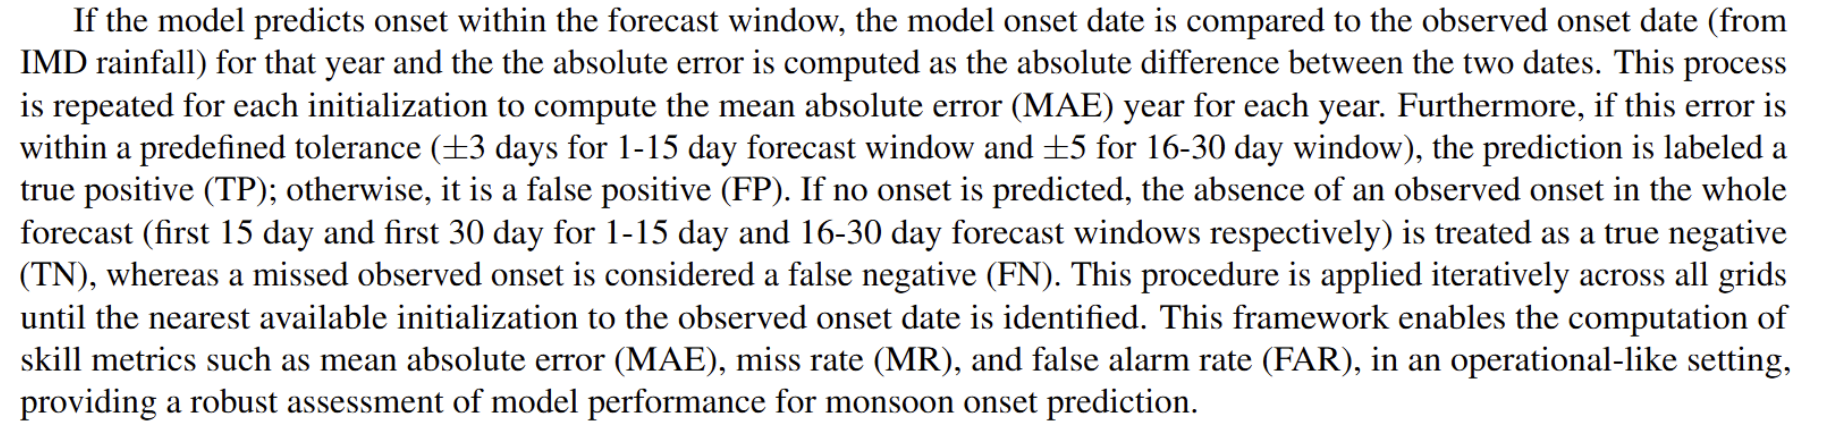

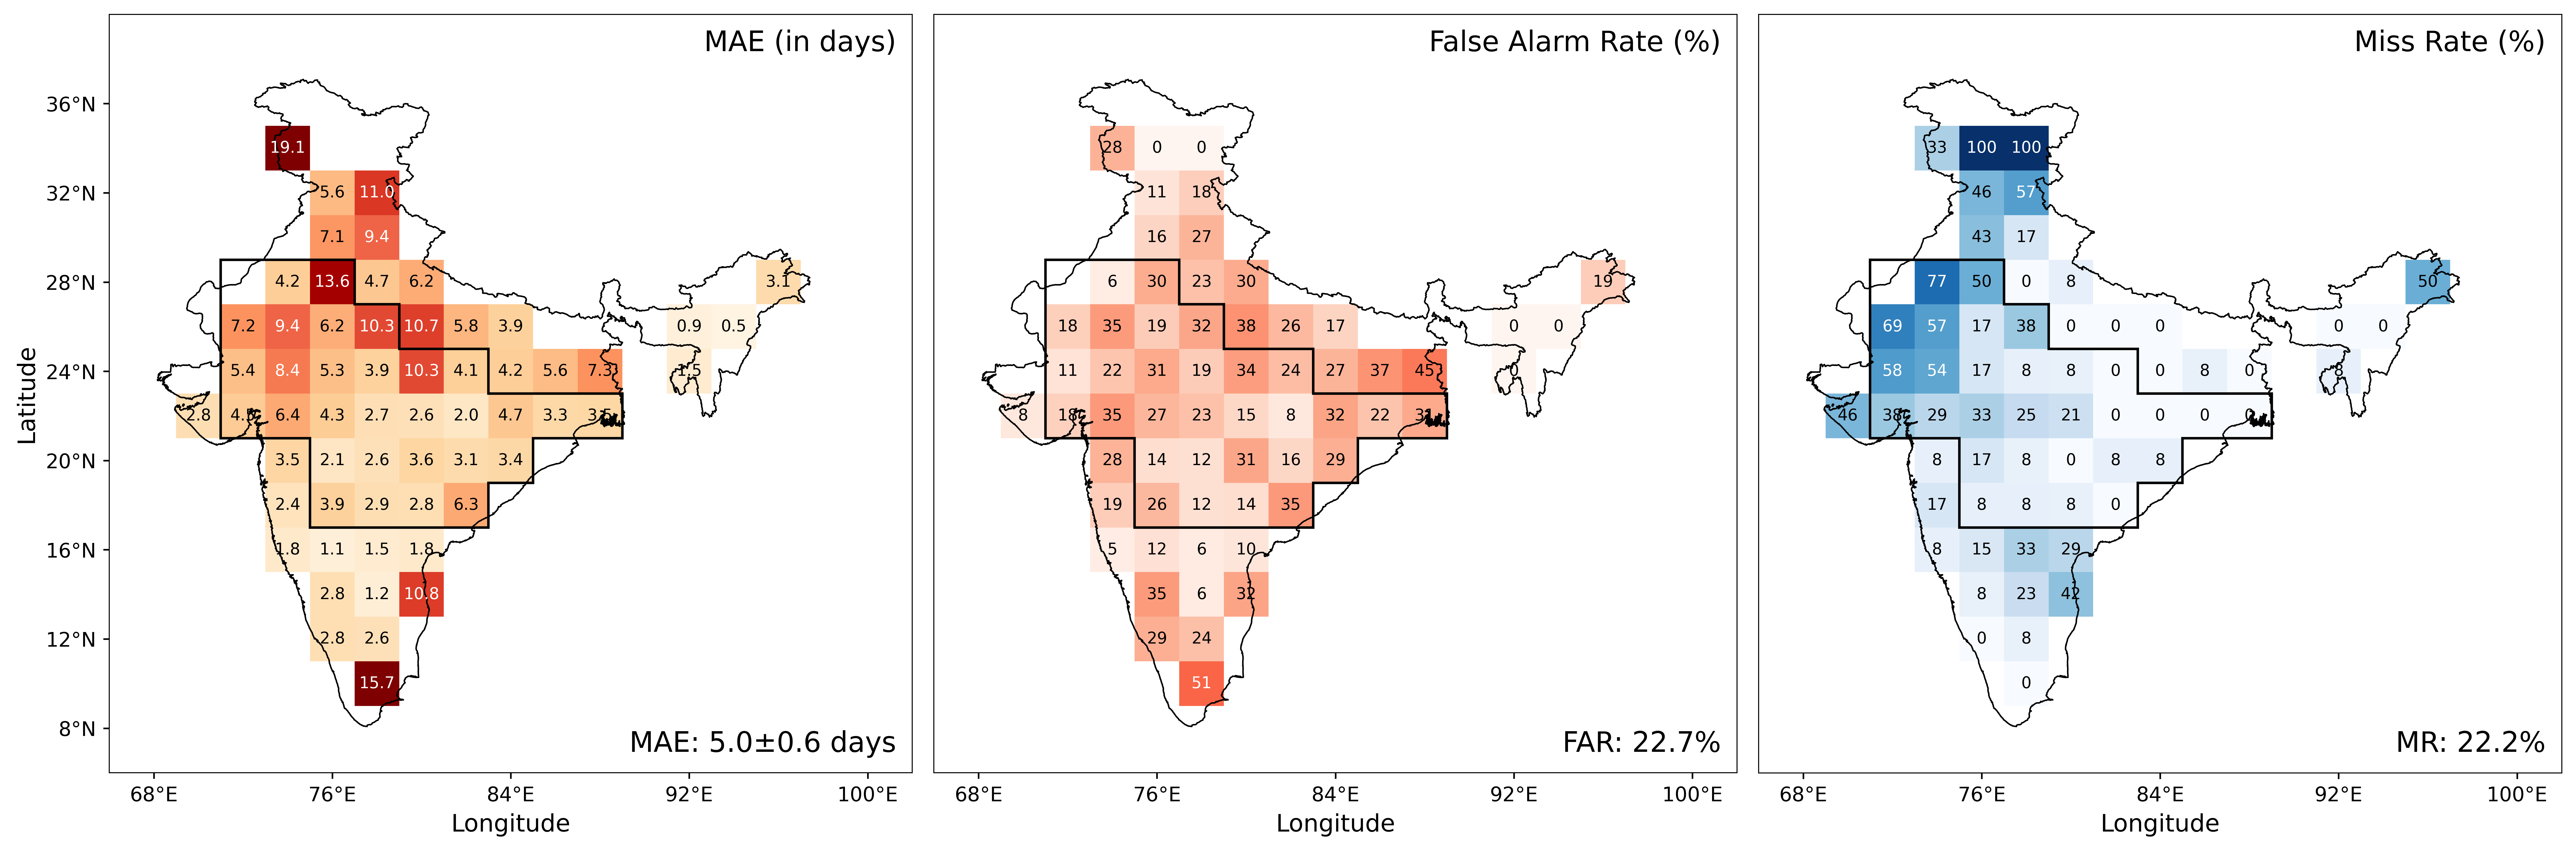

To make more sense of what we are looking at, let's break down the number we see for MAE. It says 5 += .6 days for MAE. This is the mean average error across all grid cell MAEs. For each grid cell, this number represents the average MAE across the three years (2019, 2020, 2021) of MAEs. For each grid cell in each year, biweekly predictions are made from May to early June. 

From left to right we see a map of the resulting MAE, FAR, and MR respectively from running the script. MAE results tell us that on average, predictions are off by around 5 days. FAR tells us that we have a false alarm roughly 1 in 4 times. MR tells us that we miss the onset roughly 1 in 4 times.

We can see a lot of regional discrepancy in model performance. Northwest India has the worst performance measured by MAE and MR (with MAE of 19 days and MR of up to 100%). We understandably see a 0% false alarm rate there since it seems we never predict a monsoon (100% MR). 

Central India seems to be by-and-large the area for which the models are best-equipped to estimate. This lines up fairly nicely with the Core Monsoon Zone (the black box), though the northwestern edge of it shows some elevated MAE and MR. 

These results do a great job of informing farmers about whether they should trust the model(s) to predict the monsoon for them. A farmer in southern/central India might decide to trust the prediction, but one in northwest India absolutely shouldn't based on the graphs.

### Sanity-check

The statistics seem reasonable and the data patterns make sense with what is talked about in the article. :)

## Bonus - examining other models

### Fuxi

```bash
python mae_far_mr_deterministic_models.py \
  --years 2019 2020 2021 \
  --model_forecast_dir /project/data/model_forecast_data/fuxi/output_daily_paper_0z_2p0/tp_lsm \
  --imd_folder /project/data/imd_rainfall_data/2p0 \
  --thres_file /project/data/imd_onset_threshold/mwset2x2.nc4 \
  --shpfile_path /project/data/ind_map_shpfile/india_shapefile.shp \
  --tolerance_days 3 \
  --verification_window 1 \
  --forecast_days 15 \
  --mok \
  --output_file ./output/results_1-15day_MOK.nc \
  --plot_dir ./output/plots
```

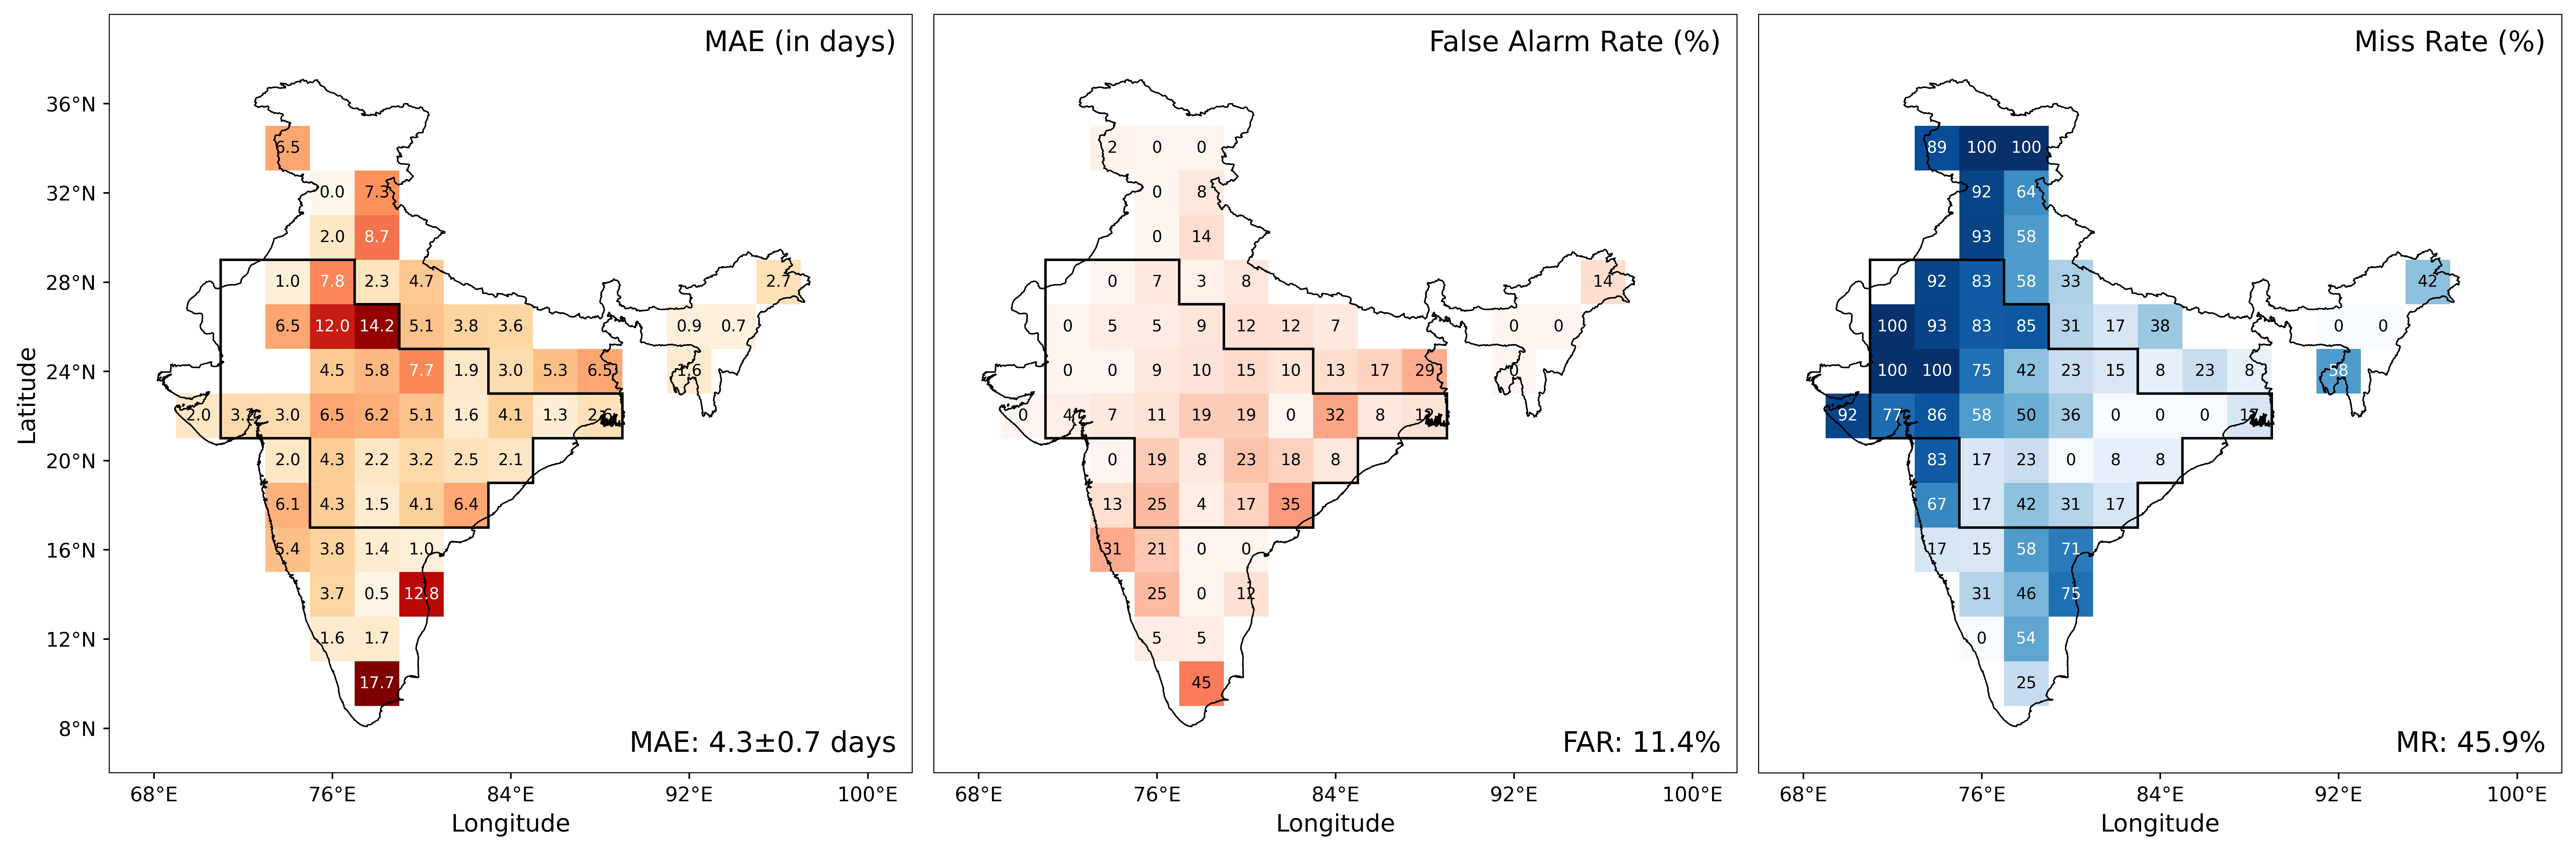

### Graphcast37

```bash
python mae_far_mr_deterministic_models.py \
  --years 2019 2020 2021 \
  --model_forecast_dir /project/data/model_forecast_data/graphcast37/output_twice_weekly_paper_0z_2p0/tp_lsm \
  --imd_folder /project/data/imd_rainfall_data/2p0 \
  --thres_file /project/data/imd_onset_threshold/mwset2x2.nc4 \
  --shpfile_path /project/data/ind_map_shpfile/india_shapefile.shp \
  --tolerance_days 3 \
  --verification_window 1 \
  --forecast_days 15 \
  --mok \
  --output_file ./output/results_1-15day_MOK.nc \
  --plot_dir ./output/plots
```

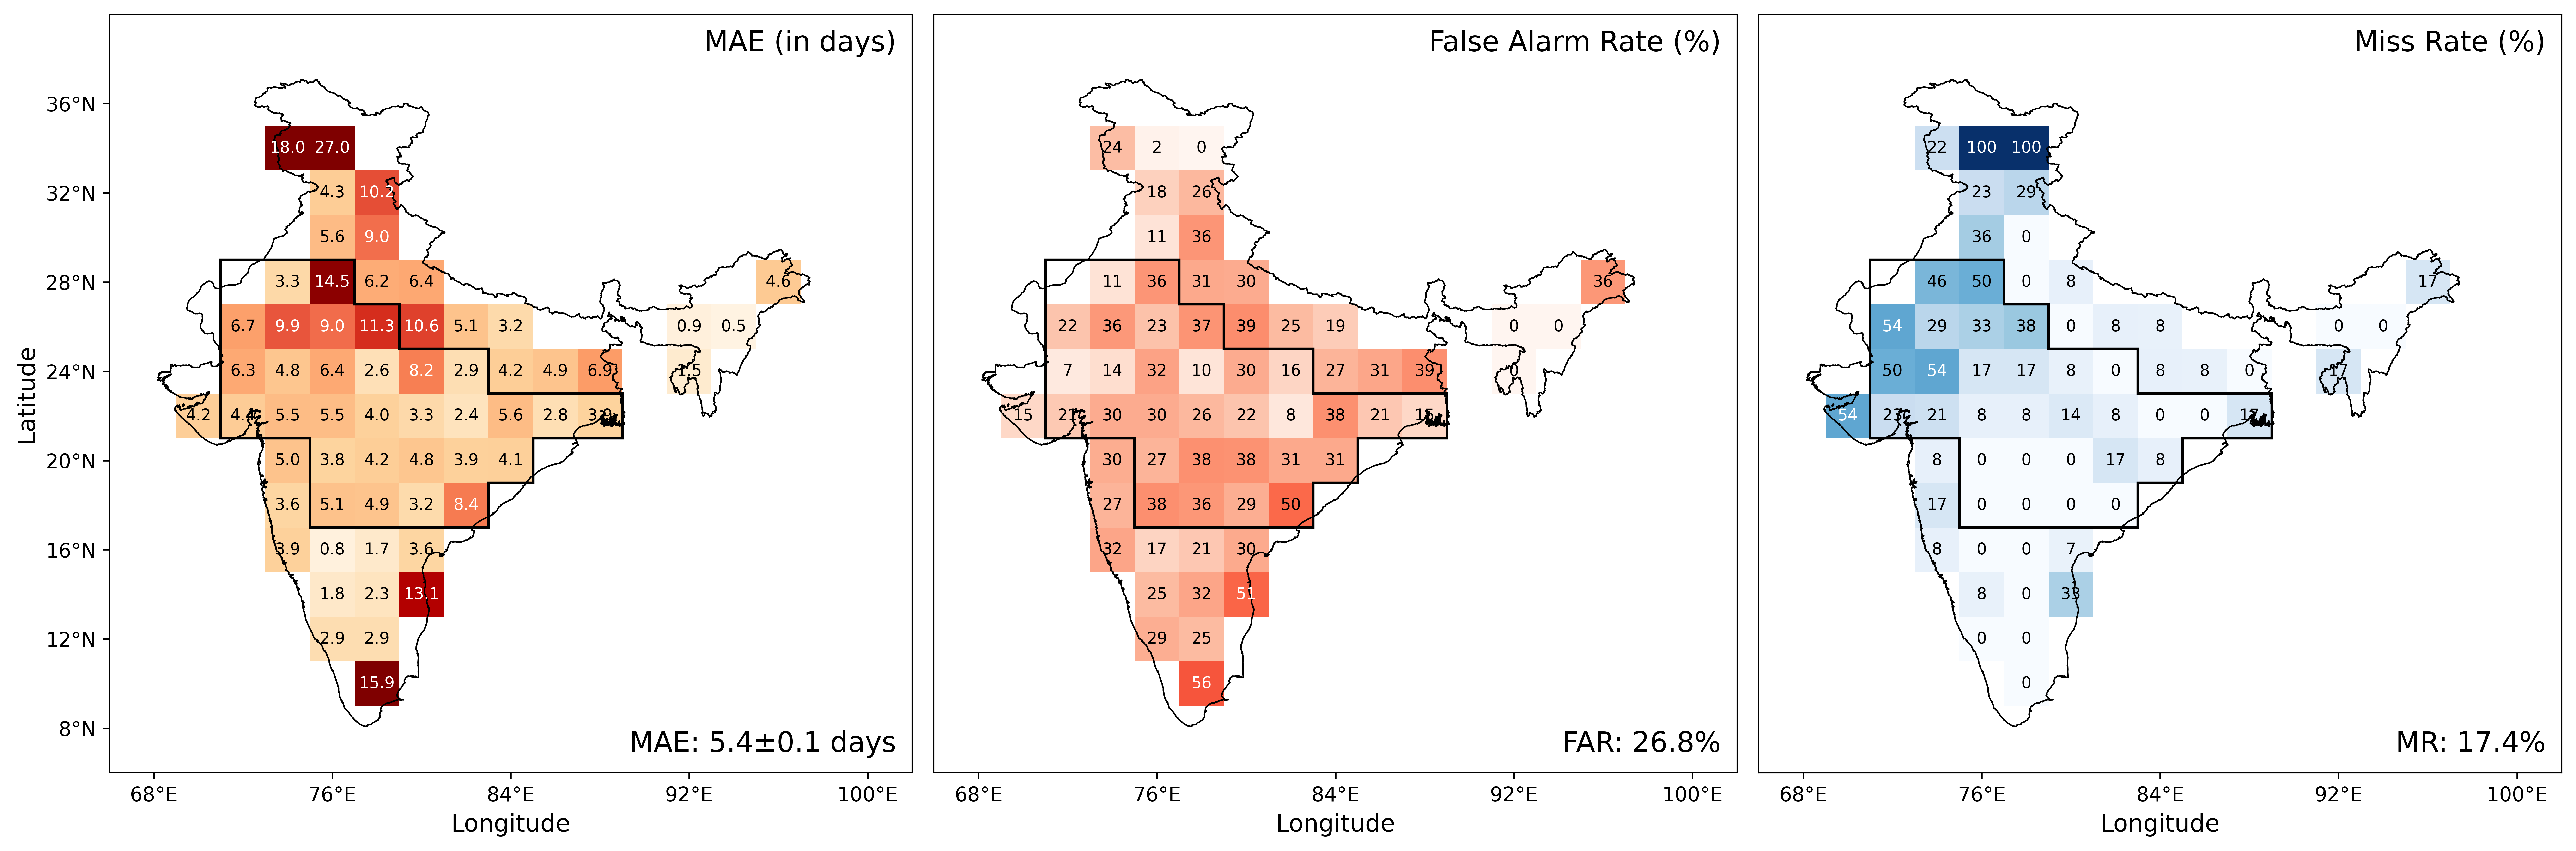